In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# remove arnings (optional)
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [3]:
# our dataset is in cocoformat, we will need pypcoco tools
!pip install pycocotools
from pycocotools.coco import COCO

Defaulting to user installation because normal site-packages is not writeable


In [4]:
from albumentations.pytorch import ToTensorV2

In [5]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [6]:
class AquariumDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [7]:
dataset_path = "plants ailments.v1i.coco/"


In [8]:
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


{0: {'id': 0, 'name': 'd', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'fusarium-wilt', 'supercategory': 'd'},
 2: {'id': 2, 'name': 'leaf-spots', 'supercategory': 'd'},
 3: {'id': 3, 'name': 'mosaic', 'supercategory': 'd'},
 4: {'id': 4, 'name': 'root-rot', 'supercategory': 'd'},
 5: {'id': 5, 'name': 'sunscald', 'supercategory': 'd'}}

In [9]:
classes = [i[1]['name'] for i in categories.items()]
classes

['d', 'fusarium-wilt', 'leaf-spots', 'mosaic', 'root-rot', 'sunscald']

In [10]:
train_dataset = AquariumDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


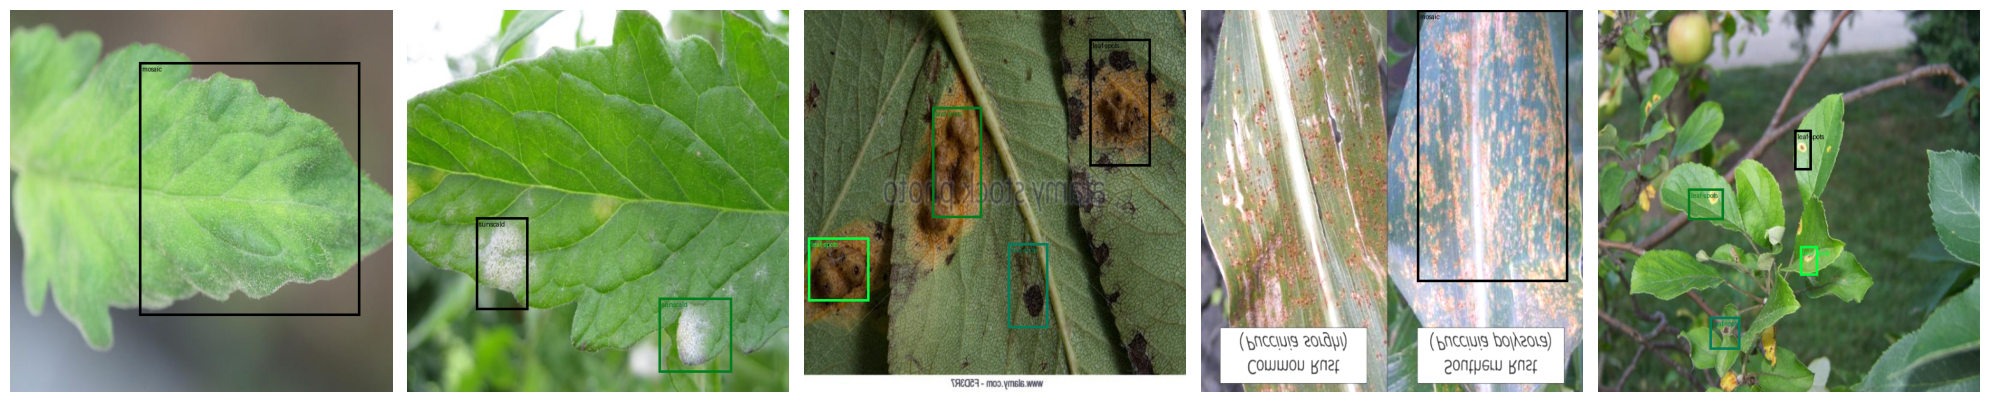

In [11]:
num_samples_to_display = 5  # Set the number of samples to display

fig, axes = plt.subplots(1, num_samples_to_display, figsize=(20, 10))

for i in range(num_samples_to_display):
    sample = train_dataset[i]  # Access each sample from the dataset
    img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)  # Convert image to tensor

    # Plot each image with bounding boxes
    axes[i].imshow(draw_bounding_boxes(
        img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
    ).permute(1, 2, 0))
    axes[i].axis('off')  # Turn off axis labels
    
plt.tight_layout()
plt.show()

In [12]:
len(train_dataset)

74

In [13]:
# lets load the faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

In [14]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [15]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [16]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

In [17]:
device = torch.device("cuda")
model = model.to(device)


In [18]:
# Now, and optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1) # lr scheduler

In [19]:
import sys

In [20]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    
#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000 # do lr warmup
#         warmup_iters = min(1000, len(loader) - 1)
        
#         lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters=warmup_iters)
    
    all_losses = []
    all_losses_dict = []
    
    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
#         if lr_scheduler is not None:
#             lr_scheduler.step() # 
        
    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [21]:
num_epochs = 25

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [00:06<00:00,  3.12it/s]


Epoch 0, lr: 0.010000, loss: 0.896994, loss_classifier: 0.426479, loss_box: 0.239876, loss_rpn_box: 0.028829, loss_object: 0.201809


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.59it/s]


Epoch 1, lr: 0.010000, loss: 0.880504, loss_classifier: 0.395065, loss_box: 0.341517, loss_rpn_box: 0.022202, loss_object: 0.121720


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.60it/s]


Epoch 2, lr: 0.010000, loss: 0.853212, loss_classifier: 0.383782, loss_box: 0.360798, loss_rpn_box: 0.021069, loss_object: 0.087564


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.58it/s]


Epoch 3, lr: 0.010000, loss: 0.823176, loss_classifier: 0.375794, loss_box: 0.356477, loss_rpn_box: 0.018040, loss_object: 0.072866


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.56it/s]


Epoch 4, lr: 0.010000, loss: 0.818614, loss_classifier: 0.382266, loss_box: 0.364608, loss_rpn_box: 0.016982, loss_object: 0.054758


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.62it/s]


Epoch 5, lr: 0.010000, loss: 0.783247, loss_classifier: 0.353867, loss_box: 0.364695, loss_rpn_box: 0.016968, loss_object: 0.047716


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.46it/s]


Epoch 6, lr: 0.010000, loss: 0.755818, loss_classifier: 0.343763, loss_box: 0.345997, loss_rpn_box: 0.016135, loss_object: 0.049923


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [00:03<00:00,  4.75it/s]


Epoch 7, lr: 0.010000, loss: 0.729573, loss_classifier: 0.326803, loss_box: 0.342996, loss_rpn_box: 0.016489, loss_object: 0.043285


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.49it/s]


Epoch 8, lr: 0.010000, loss: 0.746089, loss_classifier: 0.328152, loss_box: 0.368586, loss_rpn_box: 0.013931, loss_object: 0.035420


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.65it/s]


Epoch 9, lr: 0.010000, loss: 0.717550, loss_classifier: 0.307884, loss_box: 0.363930, loss_rpn_box: 0.013864, loss_object: 0.031871


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.60it/s]


Epoch 10, lr: 0.010000, loss: 0.731671, loss_classifier: 0.311430, loss_box: 0.374558, loss_rpn_box: 0.014151, loss_object: 0.031531


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.51it/s]


Epoch 11, lr: 0.010000, loss: 0.673099, loss_classifier: 0.276298, loss_box: 0.355252, loss_rpn_box: 0.012967, loss_object: 0.028582


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.39it/s]


Epoch 12, lr: 0.010000, loss: 0.697550, loss_classifier: 0.290692, loss_box: 0.361994, loss_rpn_box: 0.012479, loss_object: 0.032384


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.39it/s]


Epoch 13, lr: 0.010000, loss: 0.597368, loss_classifier: 0.249425, loss_box: 0.313251, loss_rpn_box: 0.011194, loss_object: 0.023499


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.35it/s]


Epoch 14, lr: 0.010000, loss: 0.631940, loss_classifier: 0.254334, loss_box: 0.343701, loss_rpn_box: 0.010736, loss_object: 0.023170


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.34it/s]


Epoch 15, lr: 0.010000, loss: 0.652646, loss_classifier: 0.256552, loss_box: 0.365938, loss_rpn_box: 0.011247, loss_object: 0.018910


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.47it/s]


Epoch 16, lr: 0.010000, loss: 0.710832, loss_classifier: 0.283345, loss_box: 0.396019, loss_rpn_box: 0.010688, loss_object: 0.020780


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.42it/s]


Epoch 17, lr: 0.010000, loss: 0.645113, loss_classifier: 0.261288, loss_box: 0.355748, loss_rpn_box: 0.010752, loss_object: 0.017325


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.55it/s]


Epoch 18, lr: 0.010000, loss: 0.602826, loss_classifier: 0.232562, loss_box: 0.343161, loss_rpn_box: 0.011155, loss_object: 0.015947


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [00:03<00:00,  4.84it/s]


Epoch 19, lr: 0.010000, loss: 0.619276, loss_classifier: 0.247476, loss_box: 0.345860, loss_rpn_box: 0.009395, loss_object: 0.016546


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.57it/s]


Epoch 20, lr: 0.010000, loss: 0.591139, loss_classifier: 0.228902, loss_box: 0.337345, loss_rpn_box: 0.009640, loss_object: 0.015251


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [00:03<00:00,  4.85it/s]


Epoch 21, lr: 0.010000, loss: 0.625847, loss_classifier: 0.239210, loss_box: 0.359108, loss_rpn_box: 0.010486, loss_object: 0.017043


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [00:03<00:00,  4.75it/s]


Epoch 22, lr: 0.010000, loss: 0.660969, loss_classifier: 0.252583, loss_box: 0.386428, loss_rpn_box: 0.008966, loss_object: 0.012990


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [00:03<00:00,  4.83it/s]


Epoch 23, lr: 0.010000, loss: 0.608364, loss_classifier: 0.232125, loss_box: 0.355235, loss_rpn_box: 0.008859, loss_object: 0.012144


100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [00:03<00:00,  4.98it/s]

Epoch 24, lr: 0.010000, loss: 0.654959, loss_classifier: 0.247275, loss_box: 0.387258, loss_rpn_box: 0.008064, loss_object: 0.012362


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


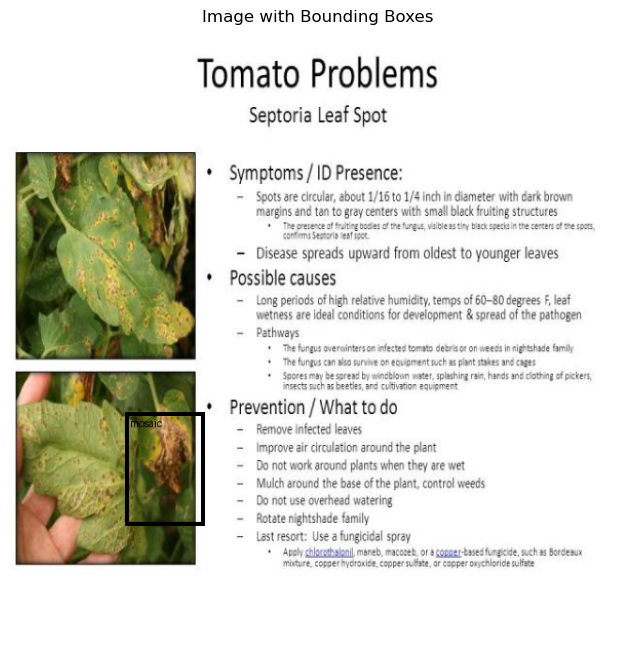

<Figure size 640x480 with 0 Axes>

Number of boxes and labels mismatch for image 1


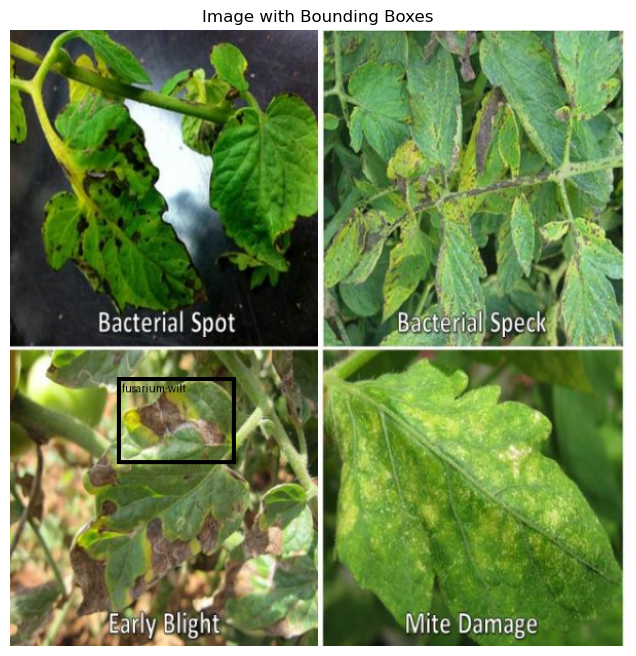

<Figure size 640x480 with 0 Axes>

Number of boxes and labels mismatch for image 2


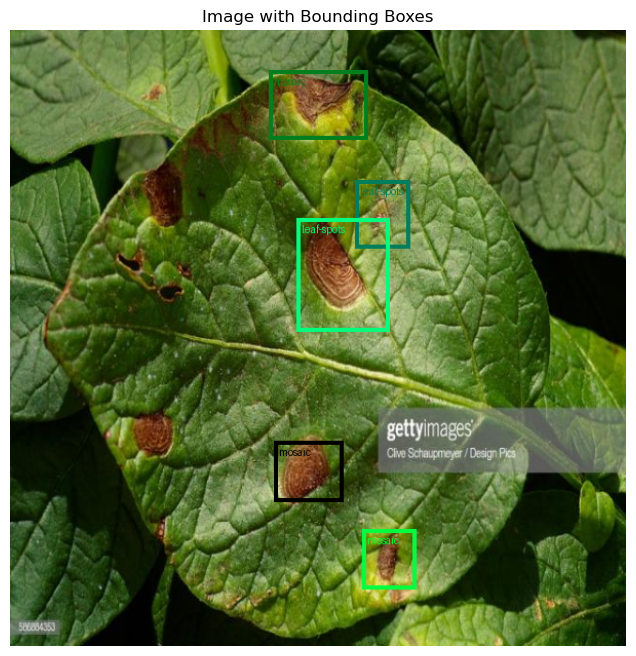

<Figure size 640x480 with 0 Axes>

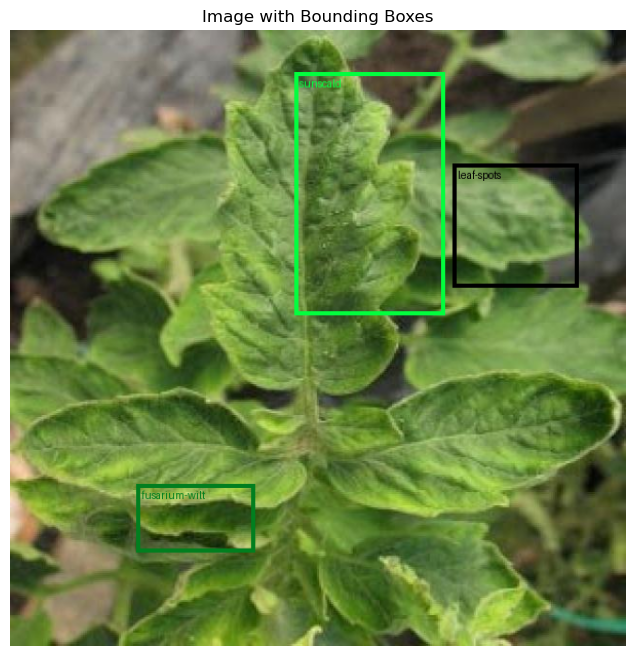

<Figure size 640x480 with 0 Axes>

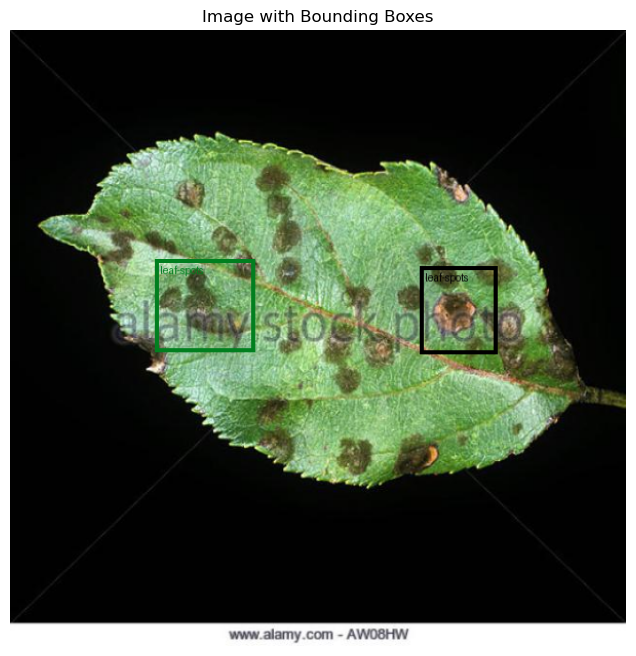

<Figure size 640x480 with 0 Axes>

In [22]:
test_dataset = AquariumDetection(root=dataset_path, split="test", transforms=get_transforms(False))
model.eval()
torch.cuda.empty_cache()

num_images_to_display = 5
count_displayed = 0

for i in range(len(test_dataset)):
    img, _ = test_dataset[i]
    with torch.no_grad():
        prediction = model([img.to(device)])
        pred = prediction[0]

    if count_displayed < num_images_to_display and len(pred['labels']) > 0:
        boxes_to_plot = pred['boxes'][pred['scores'] > 0.3]
        labels_to_plot = [classes[i] for i in pred['labels'][pred['scores'] > 0.2].tolist()]

        if len(labels_to_plot) != len(boxes_to_plot):
            print(f"Number of boxes and labels mismatch for image {i}")
            labels_to_plot = labels_to_plot[:len(boxes_to_plot)]

        img_int = torch.tensor(img * 255, dtype=torch.uint8)
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        ax.imshow(draw_bounding_boxes(img_int, boxes_to_plot, labels_to_plot, width=4).permute(1, 2, 0))
        ax.set_title('Image with Bounding Boxes')
        ax.axis('off')
        plt.show()

    
        
        for bbox, label in zip(boxes_to_plot, labels_to_plot):
            xmin, ymin, xmax, ymax = map(int, bbox.tolist())
            mask = np.zeros((img_int.shape[1], img_int.shape[2]), dtype=np.uint8)
          
       
        axes[0].imshow(img_int.permute(1, 2, 0))
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        plt.tight_layout()
        plt.show()

        count_displayed += 1

    if count_displayed >= num_images_to_display:
        break